In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import time_shift

import time
import os

root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

The data inside datasets have this form:
<center>  < identifier, timestamp, value > </center>

We will focus on intervals of timestamps.

The datetime is datetime.datetime(year, month, day, hour, minute, second, microsecond)

I had to divide the timestamp by 1000, otherwise the timestamp is not accepted by datetime.

For this specific data:
1. The First ts is 2017-9-9, a Saturday
2. The Last ts is 2018-5-22, a Tuesday

Now we look the frequency of data in different granularity

Then we will move to first analysis:
I'll plot the number of measurement we have each day for one dataset

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9.0
fig_size[1] = 10.0 
plt.rcParams["figure.figsize"] = fig_size

def print_daily_frequencies(data_frame):
    """
    :param data_frame: pandas data frame
        data to plot frequencies (one column of timestamps)
    :param delta: timedelta
        timedelta we want to know frequencies
    :return: None
        print date and number of data within the day
    """
    
    first_ts = data_frame.iloc[0] / 1000.0
    last_ts = data_frame.iloc[-1] / 1000.0
    
    delta = timedelta(days=1)
    
    first_day = datetime.fromtimestamp(first_ts).date()
    last_day = datetime.fromtimestamp(last_ts).date() + delta

    first_ts = time.mktime(first_day.timetuple())
    last_ts = time.mktime(last_day.timetuple())
    
    date = first_day
    i = 0

    measures = dict()

    while date <= last_day and i < len(data_frame):
    # add also first and last measurement for the day
        next_date = date+delta
    
        max_ts = time.mktime(next_date.timetuple())
    
        measures[date] = 0
        
        fod = datetime.fromtimestamp(data_frame.iloc[i]/1000.0)

        while (i < len(data_frame)) and ((data_frame.iloc[i]/1000.0) < max_ts):
            measures[date] += 1
            i = i+1
        
        lod = datetime.fromtimestamp(data_frame.iloc[i-1]/1000.0)

        measures[date] = (measures[date], fod, lod)
        
        date = next_date
        
    for k in measures:
        if measures[k][0] > 0:
            print(k, measures[k][0], measures[k][1].time(), measures[k][2].time())

From the datasets, the only days with effective measurements are 5:
* 2017-09-09, Saturday - 9h of mearuements (evening)
* 2017-09-10, Sunday - 24h of measurements
* 2017-09-11, Monday - 24h of measurements
* 2017-09-12, Tuesday - 3h of measurements (night only), 15 hour in one case
* 2018-05-22, Tuesday - 1h of mesurements (morning)

In [3]:
def count_intervals(a, to_sec = False):
    tmp = {}
    for x in a:
        x = int(round(x)) if to_sec else x
        tmp[x] = tmp.get(x, 0) + 1
    t = []
    for k in tmp:
        t.append((k, tmp[k]))
    t.sort()
    X = []
    Y = []
    for x, y in t:
        X.append(x)
        Y.append(y)
    return X, Y


def plot_bars(root, path_list, first_datetime, last_datetime, ax):

    fts = time.mktime(first_datetime.timetuple())
    lts = time.mktime(last_datetime.timetuple())
    
    df_list = []
    
    for path in path_list:
        df = pd.read_csv(os.path.join(root, path), header = None)
        df = df[(df[1] / 1000.0 > fts) & (df[1] / 1000.0 < lts)]
        df = time_shift(df)
        x = df.iloc[:,3].values
        
        info = df.iloc[0,0].split('/')
        node = info[1] + ',' + info[2]
        
        x, y = count_intervals(x)
        
        curr_df = pd.DataFrame(y, x, columns = [node])
        
        df_list.append(curr_df)
    
    df = df_list[0]
    for x in df_list[1:]:
        df = df.combine_first(x)
    
    df = df.fillna(0)
    df.plot(ax = ax, kind='bar')
    ax.set_title("from" +str(first_datetime) + " to " + str(last_datetime))
    ax.set_xlabel('time-steps')
    ax.set_ylabel('# of measurements')
    ax.set_yscale('log')
    ax.grid()
    ax.legend()

    
def plot_all(root, path_list, first_datetime, last_datetime, ax, hist = False):
    fts = time.mktime(first_datetime.timetuple())
    lts = time.mktime(last_datetime.timetuple())
    
    for path in path_list:
        df = pd.read_csv(os.path.join(root, path), header = None)
        df = df[(df[1] / 1000.0 > fts) & (df[1] / 1000.0 < lts)]
        df = time_shift(df)
        x = df.iloc[:,3].values
        
        info = df.iloc[0,0].split('/')
        node = info[1]
        node_type = info[2]
        
        if hist:
            ax.hist(x, 100, histtype='step', density = False, label = node + ',' + node_type, linewidth = 2.0)
        else:
            x, y = count_intervals(x)
            ax.plot(x, y, 'o-', label = node + ',' + node_type)
    
    ax.set_title("from" +str(first_datetime) + " to " + str(last_datetime))
    ax.set_xlabel('time-steps')
    ax.set_ylabel('# of measurements')
    ax.set_yscale('log')
    ax.grid()
    ax.legend()


## Tuesday
### Morning

The data from this day is already on a single hour (roughly), we can start by analyzing this one 

<IPython.core.display.Javascript object>


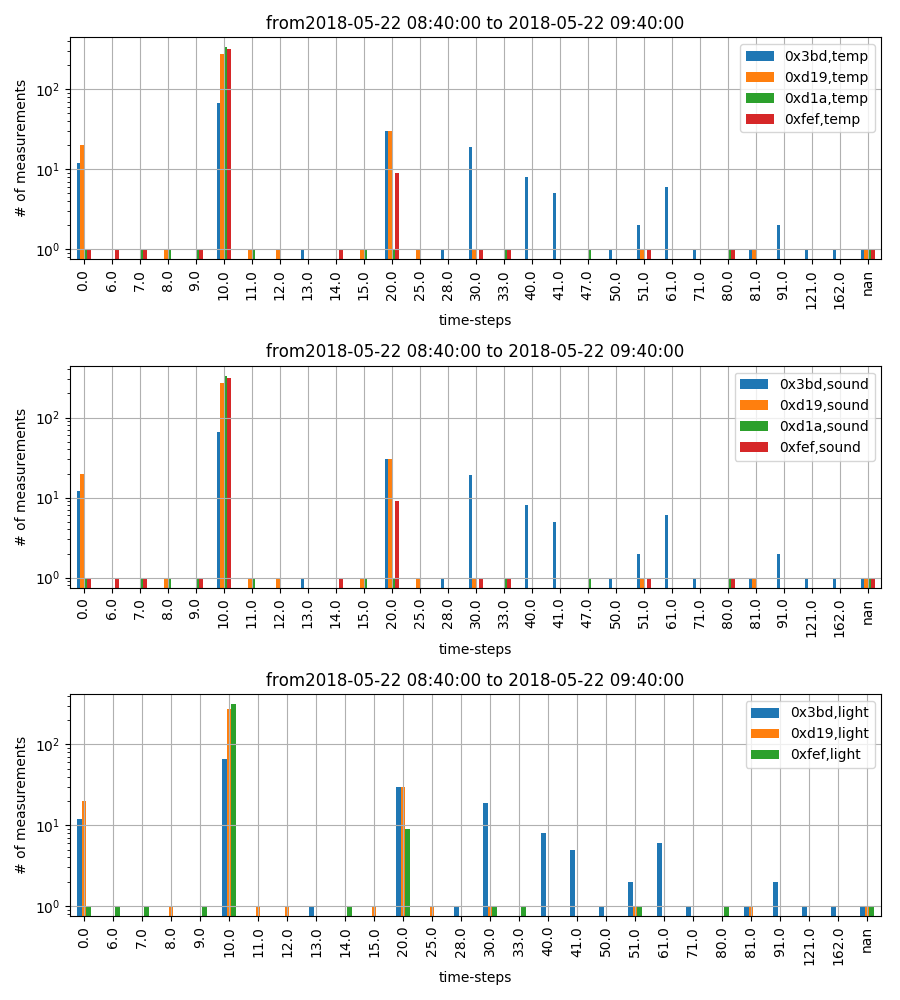

In [4]:
fts = datetime(year=2018, month=5, day=22, hour=8, minute=40)
lts = datetime(year=2018, month=5, day=22, hour=9, minute=40)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Tuesday Morning')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

The Data in the first 3 cases has most of transmission within 10 second.

In one case, the transmissions are mostly dalayed, but with the majority is still within 10 seconds. 

## Sunday

The first thing I'll do is to plot number of measurements per hour.

> There are some hours I have to focus on?

In [5]:
def print_hourly_frequencies(data_frame):
    """
    :param data_frame: pandas data frame
        data to plot frequencies (one column of timestamps)
    :param delta: timedelta
        timedelta we want to know frequencies
    :return: None
        print date and number of data within the day
    """
    
    first_ts = data_frame.iloc[0] / 1000.0
    last_ts = data_frame.iloc[-1] / 1000.0
    
    delta = timedelta(hours=1)
    
    first_hour = datetime.fromtimestamp(first_ts)
    last_hour = datetime.fromtimestamp(last_ts) + delta

    first_ts = time.mktime(first_hour.timetuple())
    last_ts = time.mktime(last_hour.timetuple())
    
    hour = first_hour
    i = 0

    measures = dict()

    while hour <= last_hour and i < len(data_frame):
    # add also first and last measurement for the day
        next_hour = hour+delta
    
        max_ts = time.mktime(next_hour.timetuple())
    
        measures[hour] = 0

        while (i < len(data_frame)) and ((data_frame.iloc[i]/1000.0) < max_ts):
            measures[hour] += 1
            i = i+1
        
        measures[hour] = measures[hour]
        
        hour = next_hour
        
    for k in measures:
        if measures[k] > 0:
            print(k, measures[k])
    
    return measures

We have almost the same number of measurements per hour for each sensors.
Except one sensor, for which the data transmitted is much less:

> * 3:00
> * 18:00
> * 19:00

(This is true also for the other kind of sensors)

### Sunday Morning

For morning hour, I will consider an interval close to the one already seen in the previous case 8:00-9:00

<IPython.core.display.Javascript object>


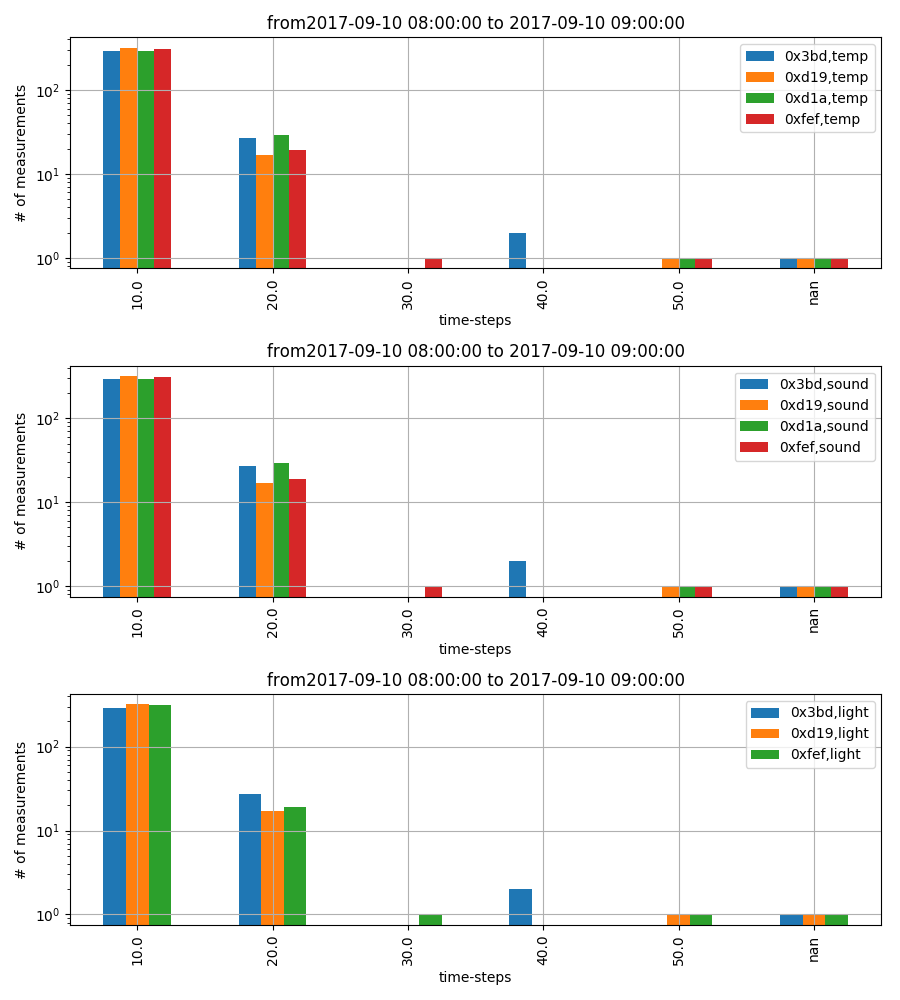

In [6]:
fts = datetime(year=2017, month=9, day=10, hour=8, minute=0)
lts = datetime(year=2017, month=9, day=10, hour=9, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Sunday Morning')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

For all sensors, the measurements are largely withn 10-14 seconds, only in few cases we have a delay over 20 seconds.

### Sunday Evening

Here I'll consider the time period between 19-20 which is the one with the most losses

<IPython.core.display.Javascript object>


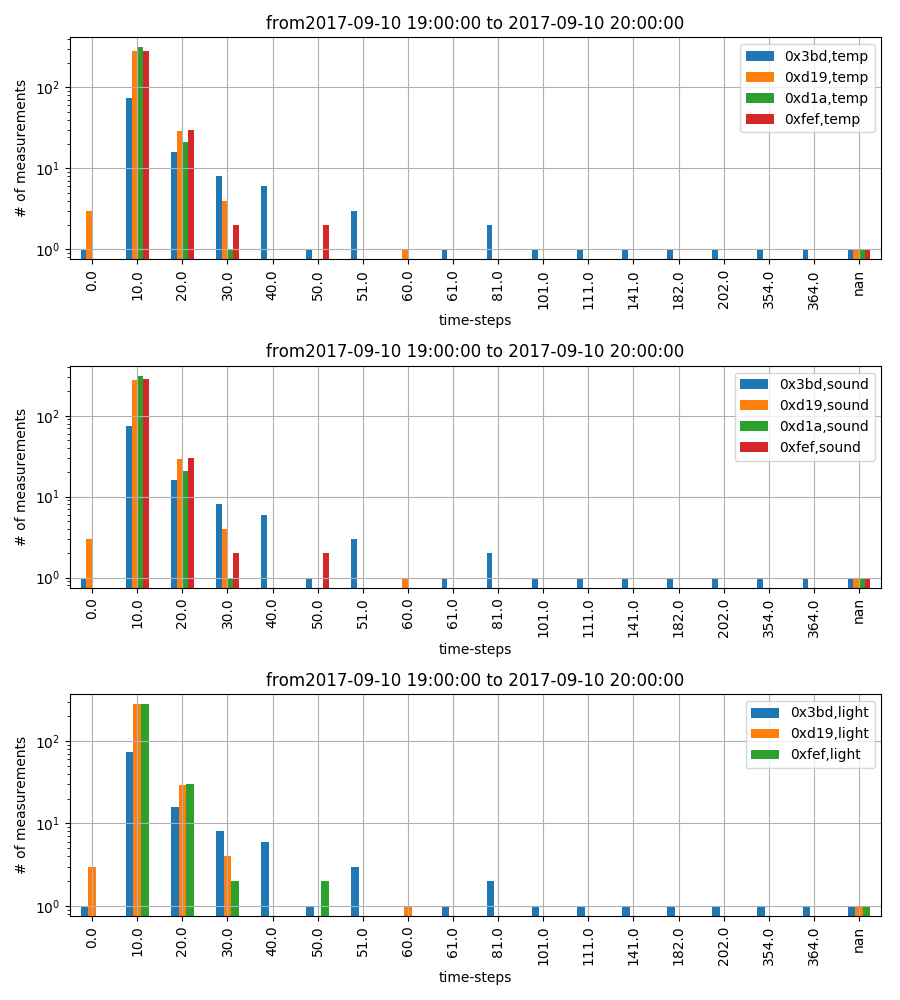

In [7]:
fts = datetime(year=2017, month=9, day=10, hour=19, minute=0)
lts = datetime(year=2017, month=9, day=10, hour=20, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Sunday Evening')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

In one case there is an high instability, since the transmission spreads from 10 to 50 seconds

### Sunday Night

<IPython.core.display.Javascript object>


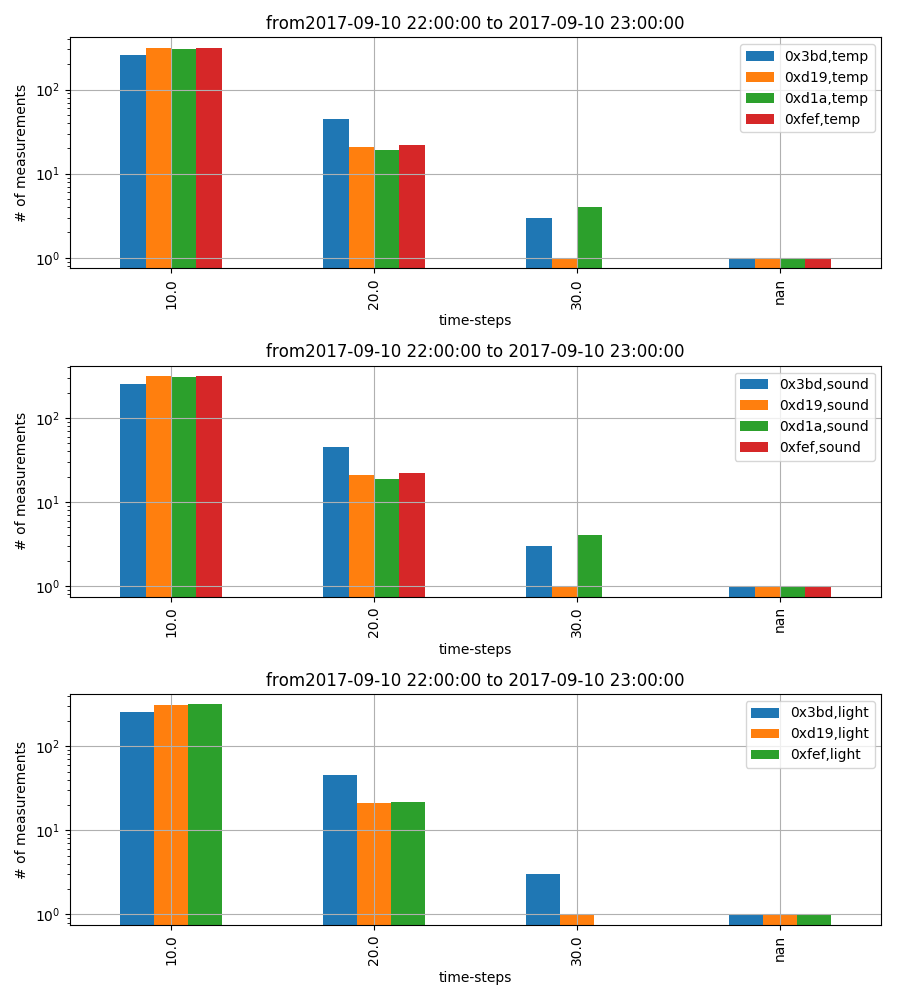

In [8]:
fts = datetime(year=2017, month=9, day=10, hour=22, minute=0)
lts = datetime(year=2017, month=9, day=10, hour=23, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Sunday Night')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

## Monday

### Monday Morning
I will consider the same time interval 8-9. In this time period one of the sensors has also a very few transmissions.

<IPython.core.display.Javascript object>


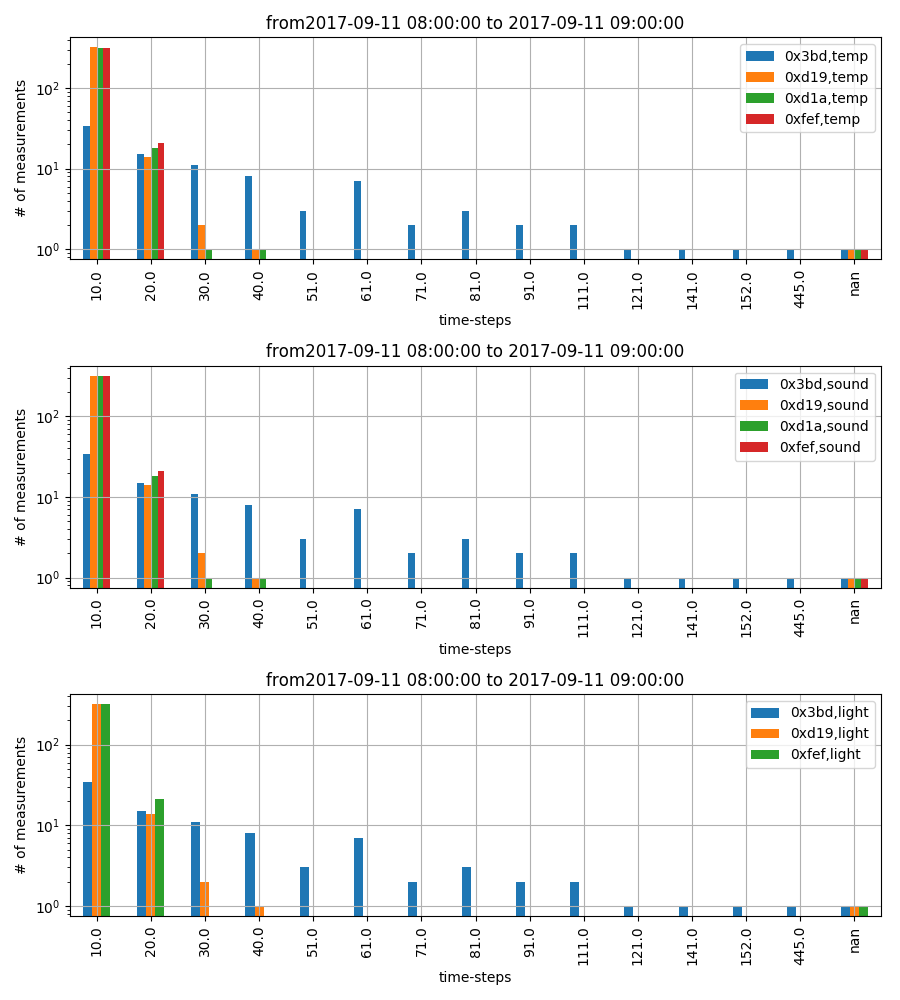

In [9]:
fts = datetime(year=2017, month=9, day=11, hour=8, minute=0)
lts = datetime(year=2017, month=9, day=11, hour=9, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Monday Morning')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

The sensors with few transmission is the same of Sunday Evening, the transmissions go largely over 50s.

### Monday Evening

<IPython.core.display.Javascript object>


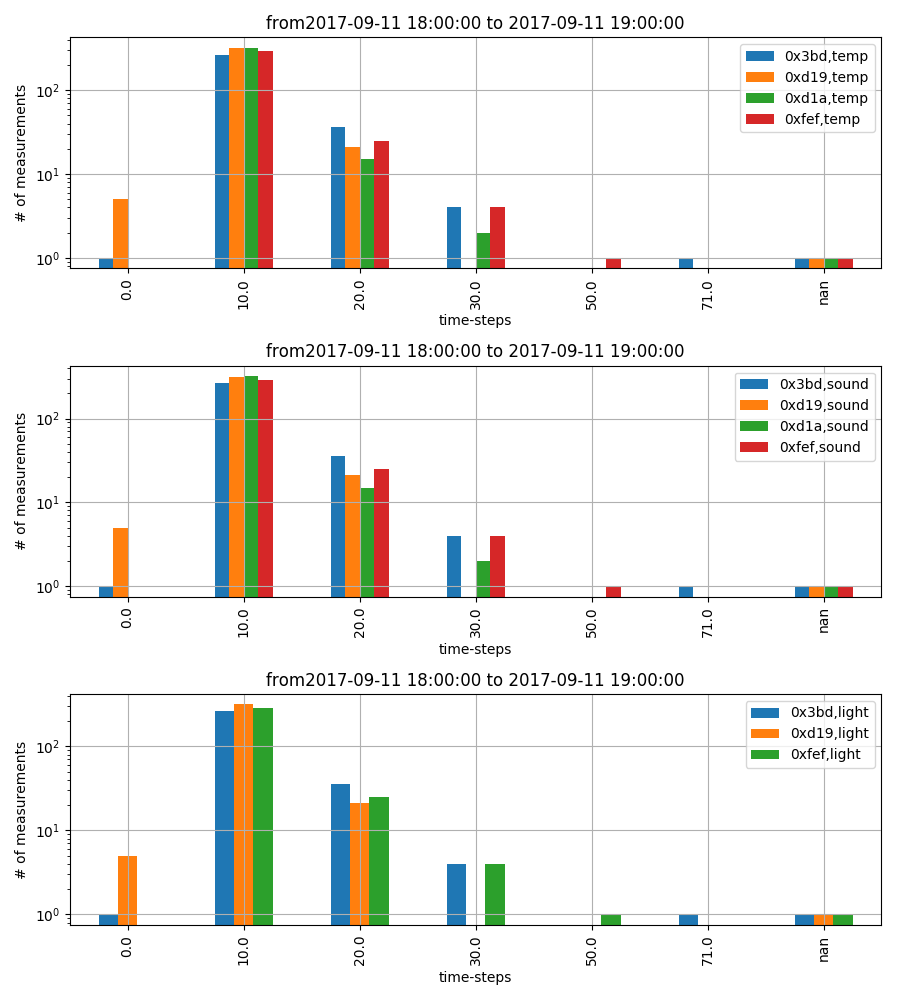

In [10]:
fts = datetime(year=2017, month=9, day=11, hour=18, minute=0)
lts = datetime(year=2017, month=9, day=11, hour=19, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Monday Evening')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

In the same day, the same sensor returned to work with transmission mostly within 10s. 

### Monday Night

<IPython.core.display.Javascript object>


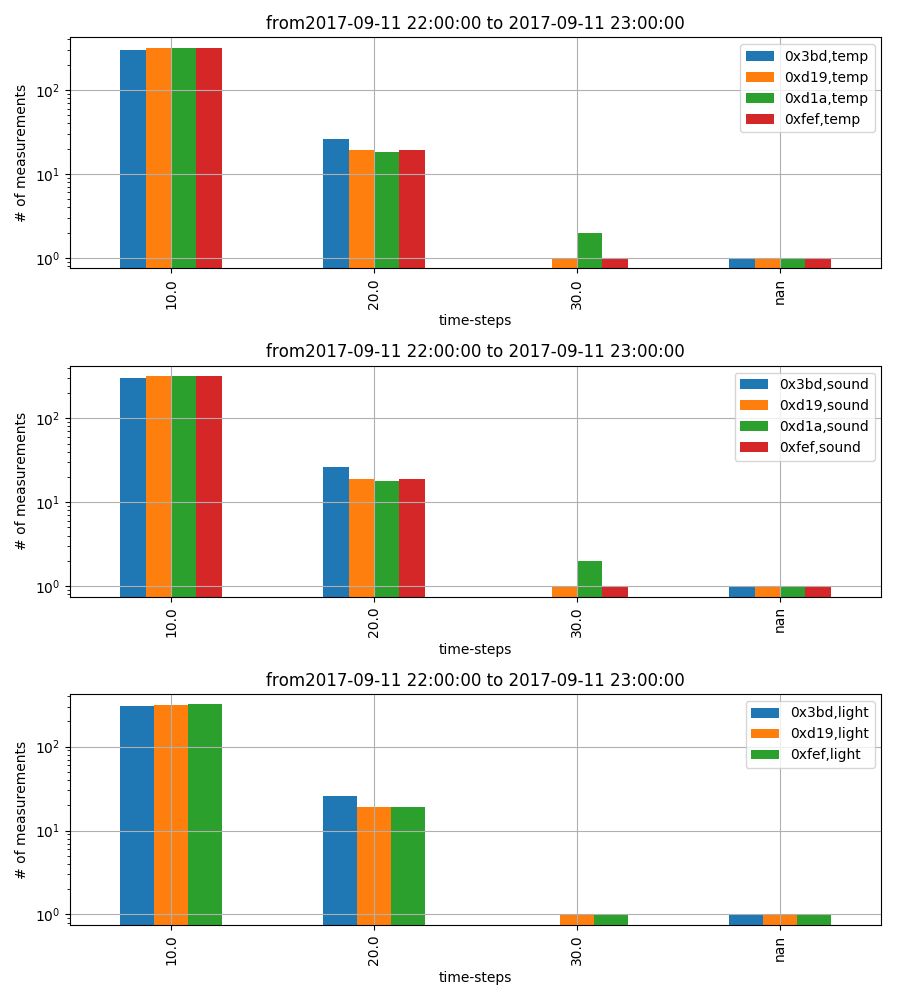

In [11]:
fts = datetime(year=2017, month=9, day=11, hour=22, minute=0)
lts = datetime(year=2017, month=9, day=11, hour=23, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1, num = 'Monday Night')
plot_bars(root, t_path, fts, lts, axes[0])
plot_bars(root, s_path, fts, lts, axes[1])
plot_bars(root, l_path, fts, lts, axes[2])
fig.tight_layout()
plt.show()

All the sensors works with almost the same transmission rate.

# Comparing Sensors

Looking at the number of measurements per hour of all the sensors, there are some similar pattern.
How close are them?

## Tuesday
### Morning

<IPython.core.display.Javascript object>


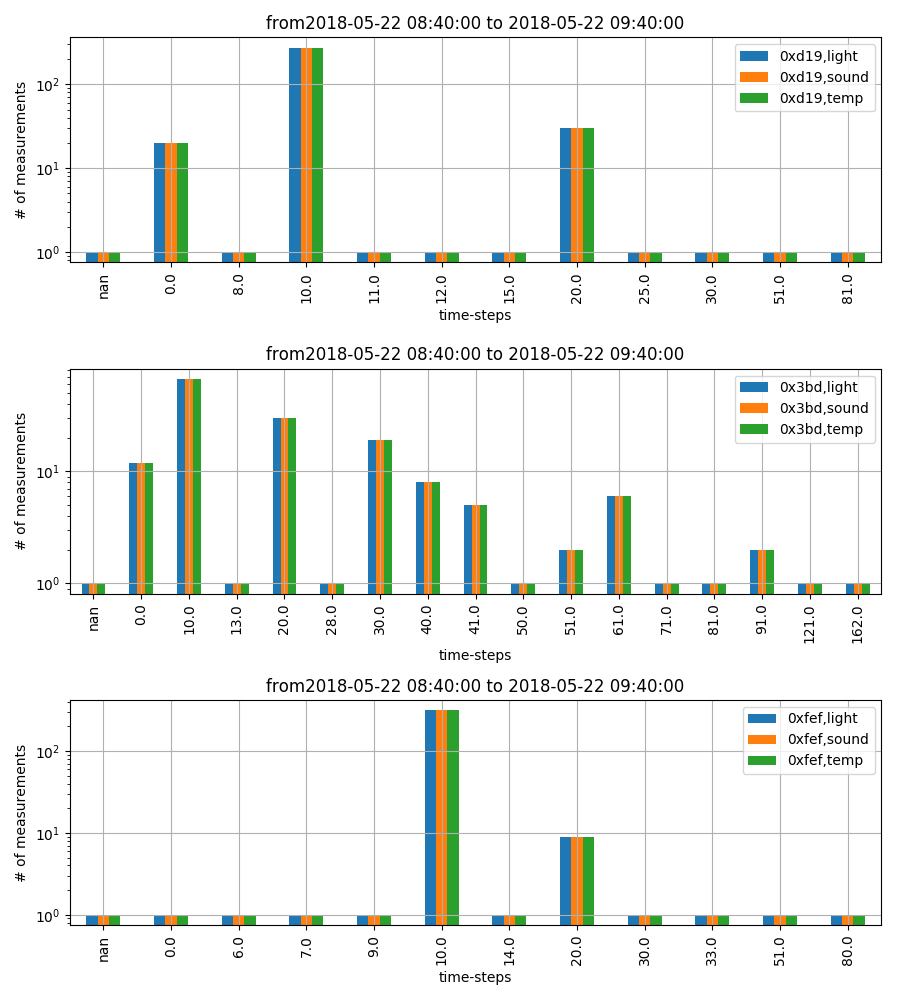

In [12]:
fts = datetime(year=2018, month=5, day=22, hour=8, minute=40)
lts = datetime(year=2018, month=5, day=22, hour=9, minute=40)

fig, axes = plt.subplots(nrows=3, ncols=1)
plot_bars(root, [t_path[2], s_path[2], l_path[2]], fts, lts, axes[0])
plot_bars(root, [t_path[0], s_path[0], l_path[0]], fts, lts, axes[1])
plot_bars(root, [t_path[1], s_path[1], l_path[1]], fts, lts, axes[2])
fig.tight_layout()
plt.show()

## Sunday
### Evening

<IPython.core.display.Javascript object>


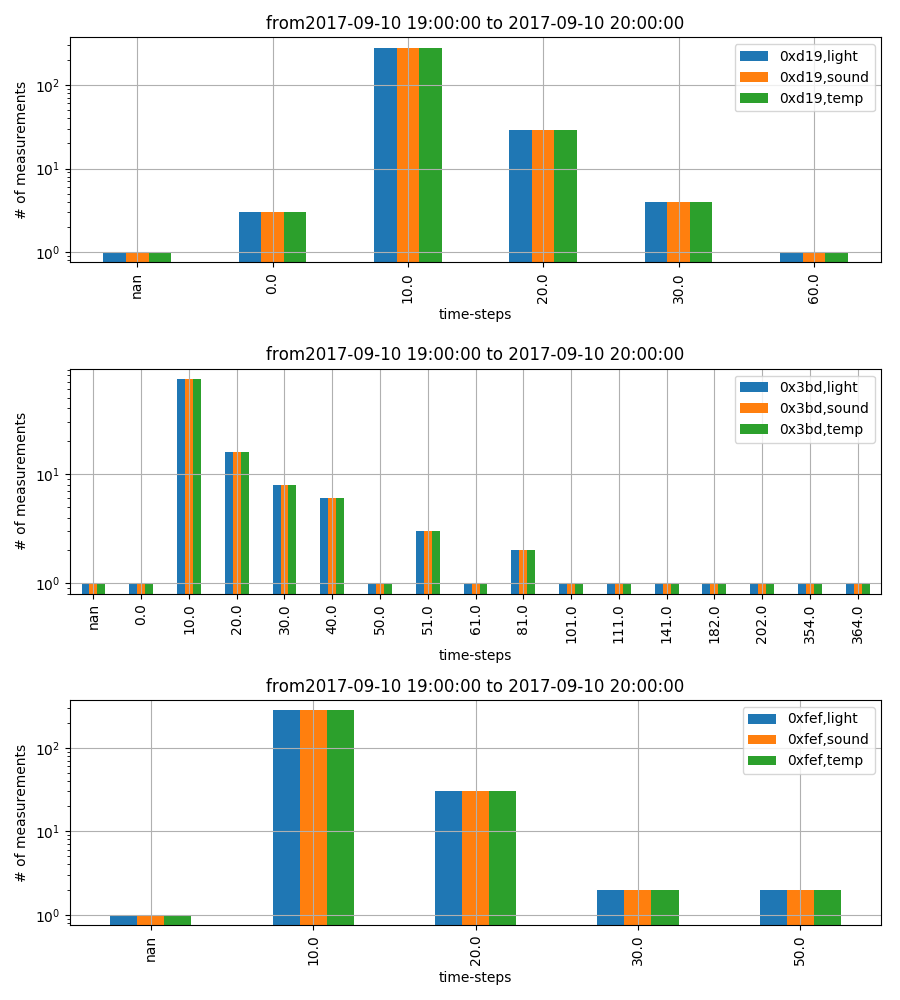

In [13]:
fts = datetime(year=2017, month=9, day=10, hour=19, minute=0)
lts = datetime(year=2017, month=9, day=10, hour=20, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1)
plot_bars(root, [t_path[2], s_path[2], l_path[2]], fts, lts, axes[0])
plot_bars(root, [t_path[0], s_path[0], l_path[0]], fts, lts, axes[1])
plot_bars(root, [t_path[1], s_path[1], l_path[1]], fts, lts, axes[2])
fig.tight_layout()
plt.show()

## Monday
### Morning

<IPython.core.display.Javascript object>


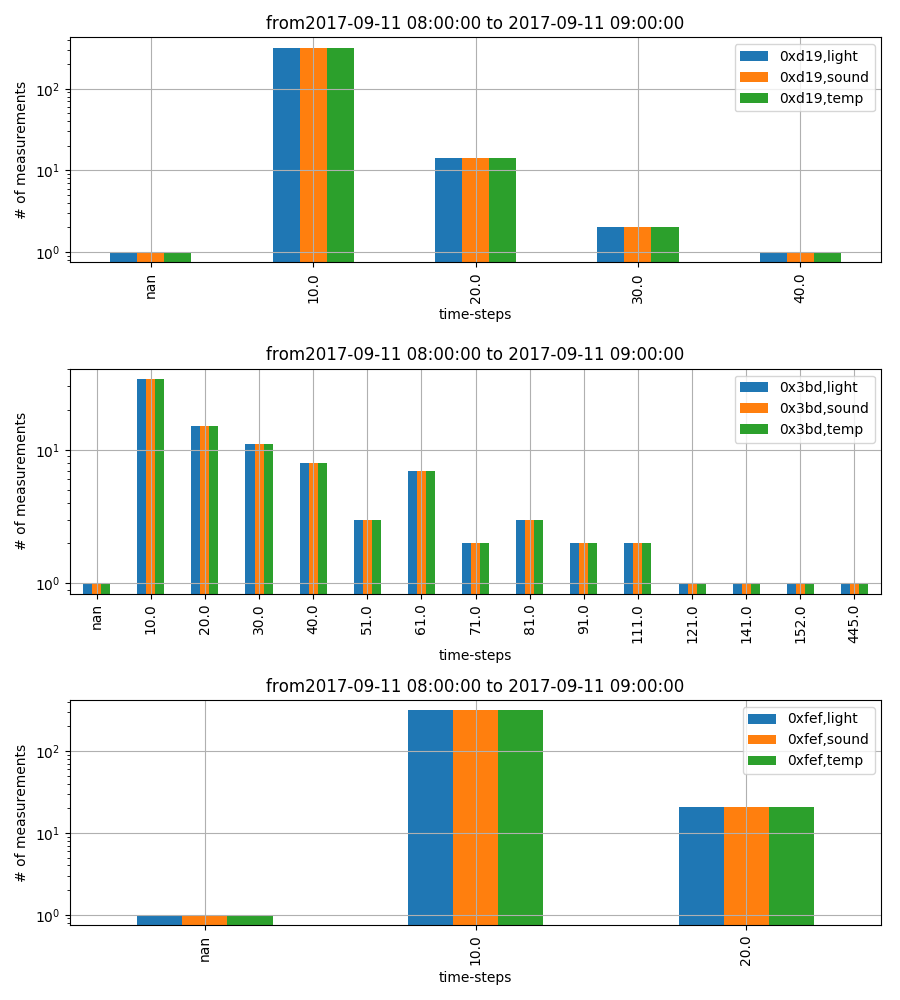

In [14]:
fts = datetime(year=2017, month=9, day=11, hour=8, minute=0)
lts = datetime(year=2017, month=9, day=11, hour=9, minute=0)

fig, axes = plt.subplots(nrows=3, ncols=1)
plot_bars(root, [t_path[2], s_path[2], l_path[2]], fts, lts, axes[0])
plot_bars(root, [t_path[0], s_path[0], l_path[0]], fts, lts, axes[1])
plot_bars(root, [t_path[1], s_path[1], l_path[1]], fts, lts, axes[2])
fig.tight_layout()
plt.show()